# WeaveForward — Fiber Donation Recommendation Pipeline

| Step | Notebook | Purpose | Output |
|------|----------|---------|--------|
| 1 | `webscraper_extraction.ipynb` | Scrape PH + multinational brand sites, parse fiber compositions, compute biodeg tiers | `data/webscraped_data/webscraped_catalog.csv` |
| 2 | **`fiber_recommendation_model.ipynb`** ← *this file* | Load scraper CSV → NCR geocoded donor requests (Nominatim OSM) → Spark ETL → Feature engineering → Seaborn visualizations → CatBoost donation recommendation model | Trained model (`models/catboost_donation_rec.cbm`), visualizations |

> **Run order:** `webscraper_extraction.ipynb` → this notebook.
>
> **Target variable:** `donation_decision` — `accept` / `conditional` / `decline`  
> based on fiber biodegradability, dominant fiber, clothing type, and NCR city demand index.
>
> **Django REST API** (`WeaveForward_Recommendation_API/`) is a standalone project on disk.  
> Run `python manage.py runserver` from that folder after training the model here.
>
> **Note:** For testing environment, only **2 PH + 2 multinational brand sites** were used to scale up development optimization.


---
## 0 · Environment Setup

In [1]:
import subprocess, sys

PACKAGES = [
    # Spark
    "pyspark",
    "delta-spark",
    # ML / Eval
    "catboost",
    "optuna",
    "scikit-learn",
    "shap",
    # Visualization / Utils
    "matplotlib",
    "seaborn",
    "tqdm",
    "python-dotenv",
    "numpy",
    "pandas",
    "pyarrow",
    # Geocoding
    "geopy",
    "requests",
]

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *PACKAGES])

import os
from pathlib import Path

ROOT       = Path("..").resolve()
DATA_DIR   = ROOT / "data"
WEB_DIR    = DATA_DIR / "webscraped_data"
PROC_DIR   = DATA_DIR / "processed"
MODEL_DIR  = ROOT / "models"
SPARK_WH   = DATA_DIR / "spark_warehouse"
VIZ_DIR    = DATA_DIR / "visualizations"

for d in [WEB_DIR, PROC_DIR, MODEL_DIR, SPARK_WH, VIZ_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("✓ environment ready")


✓ environment ready



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


---
## 1 · Imports & Global Config

In [2]:
import numpy as np
import pandas as pd
import json, re, uuid, time, random, logging, glob, shutil
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import optuna
import shap
import requests

from pathlib     import Path
from datetime    import datetime
from tqdm        import tqdm
from dotenv      import load_dotenv
from geopy.geocoders         import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# PySpark
from pyspark.sql        import SparkSession
from pyspark.sql        import functions as F
from pyspark.sql.types  import (StructType, StructField, StringType,
                                 DoubleType, IntegerType, BooleanType)

# ML
from catboost        import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score
)

load_dotenv()
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✓ imports ready")


✓ imports ready


In [35]:
# ── Visualization theme & color palette ──────────────────────────────────
EARTH = ["#5c4a2a", "#7a6040", "#9b7d54", "#b89a6e", "#d4b896",
         "#8b6914", "#6b8e23", "#4a7c59", "#2d6a4f", "#1b4332"]
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams.update({"figure.dpi": 130, "figure.figsize": (12, 5)})

# ── Historical visualization paths ───────────────────────────────────────
_RUN_TS  = datetime.now().strftime("%Y%m%d_%H%M%S")
VIZ_HIST = VIZ_DIR / "history"
VIZ_HIST.mkdir(parents=True, exist_ok=True)

def viz_path(stem: str) -> Path:
    """Return a timestamped path under VIZ_DIR/history/.
    Each notebook run produces uniquely named files so historical runs are preserved."""
    return VIZ_HIST / f"{stem}_{_RUN_TS}.png"

print(f"✓ viz_path() ready  —  run timestamp : {_RUN_TS}")
print(f"  history dir : {VIZ_HIST}")


✓ viz_path() ready  —  run timestamp : 20260225_020618
  history dir : /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/history


### Biodegradability Score Reference & Methodology

`BIODEG_SCORES` assigns each fiber a **normalized 0–100 composite score** representing its relative rate and completeness of biodegradation under typical environmental conditions (soil burial / composting / marine). Three fibers are **directly anchored** to measured % degradation values from Zambrano et al. (2019); all remaining fibers are calibrated on the same scale using peer-reviewed literature.

| Tier | Score range | Fibers | Basis |
|------|-------------|--------|-------|
| High | 91–96 | linen, hemp, cotton, lyocell/Tencel | Near-complete cellulosic degradation within weeks–months; lyocell NMMO process measured ~87 % at 28 d marine |
| Medium-high | 72–83 | silk, wool, cashmere, bamboo, modal, rayon, viscose, denim | Protein fibers (keratin/fibroin) or regenerated cellulosics; slower kinetics or chemical processing reduces rate |
| Low | 4–12 | nylon, polyester, acrylic, elastane, spandex, lycra | Petroleum-based synthetics; persist decades–centuries in the environment |
| Default | 30 | unknown | Conservative midpoint for fibers with no identified composition |

**Key references:**

1. Textile Exchange. (2022). *Preferred Fiber & Materials Market Report 2022*. [https://textileexchange.org/app/uploads/2022/10/Textile-Exchange_PFMR_2022.pdf](https://textileexchange.org/app/uploads/2022/10/Textile-Exchange_PFMR_2022.pdf)

2. Zambrano, M.C., Pawlak, J.J., Daystar, J., Ankeny, M., Cheng, J.J., & Venditti, R.A. (2019). Microfibers generated from the laundering of cotton, rayon and polyester based fabrics and their aquatic biodegradation. *Marine Pollution Bulletin*, 142, 394–407. [https://doi.org/10.1016/j.marpolbul.2019.02.062](https://doi.org/10.1016/j.marpolbul.2019.02.062)

3. Henry, B., Laitala, K., & Klepp, I.G. (2019). Microfibres from apparel and home textiles: Prospects for including microplastics in environmental sustainability assessment. *Science of The Total Environment*, 652, 483–494. [https://doi.org/10.1016/j.scitotenv.2018.10.166](https://doi.org/10.1016/j.scitotenv.2018.10.166)

4. Andrady, A.L. (2011). Microplastics in the marine environment. *Marine Pollution Bulletin*, 62(8), 1596–1605. [https://doi.org/10.1016/j.marpolbul.2011.05.030](https://doi.org/10.1016/j.marpolbul.2011.05.030)

5. Muthu, S.S. (2014). *Assessing the Environmental Impact of Textiles and the Clothing Supply Chain*. Woodhead Publishing. ISBN 978-0-85709-433-4.

6. WRAP. (2017). *Valuing Our Clothes: the cost of UK fashion*. [https://wrap.org.uk/sites/default/files/2020-10/WRAP-valuing-our-clothes-the-cost-of-uk-fashion_WRAP.pdf](https://wrap.org.uk/sites/default/files/2020-10/WRAP-valuing-our-clothes-the-cost-of-uk-fashion_WRAP.pdf)

> **`BIO_FIBERS`** lists fibers classified as *natural or bio-based cellulosic*, consistent with Textile Exchange preferred fiber categories. Acetate and denim are included as cellulose derivatives despite chemical processing.

---

#### Empirical Anchoring & Derivation Notes

**Three primary anchor points** are taken directly from **Zambrano et al. (2019)** [ref. 2], which measured aquatic biodegradation of microfibers in seawater over 90 days:

| Anchor fiber | Measured % degradation (90 d seawater) | Score |
|-------------|----------------------------------------|-------|
| cotton | ~74 % | 92 |
| rayon | ~60 % | 72 |
| polyester | ~2 % | 8 |

The 0–100 scale is stretched upward for non-seawater conditions (soil burial / composting degrade cellulosics faster than seawater), hence cotton scores 92 rather than 74.

**Remaining fibers calibrated on the same scale:**
- **Lyocell / Tencel (91)**: NMMO closed-loop process leaves cellulose highly accessible; measured ~87 % marine degradation at 28 days — *faster* than cotton at the same timepoint.
- **Silk (83)**: Silk fibroin degrades faster than keratin (wool) but slower than cellulosics; silk suture studies document significant degradation within weeks in tissue/soil environments.
- **Wool / Cashmere (74)**: Keratin protein; soil burial studies document 50–70 % weight loss after 6 months — slower than any cellulosic fiber. Cashmere shares near-identical protein structure.
- **Bamboo (73)**: Apparel-grade bamboo is virtually always bamboo viscose — the same alkaline/CS₂ chemical process as rayon — giving it rayon-equivalent degradation kinetics.
- **Modal (76)**: Beech-wood viscose derivative; intermediate between rayon (72) and lyocell (91) reflecting its partially retained crystallinity.
- **Synthetics (4–12)**: Andrady (2011) [ref. 4] documents quantified persistence timescales of 20–500+ years for petroleum-based polymers in marine environments.

For the closest available **published numeric scoring systems**, see:

**Sustainable Apparel Coalition — Higg Materials Sustainability Index (MSI)**  
Industry-standard LCA-based tool assigning numeric environmental impact scores per kg of fiber.  
→ [https://apparelcoalition.org/higg-msi/](https://apparelcoalition.org/higg-msi/)

**MADE-BY Environmental Benchmark for Fibres**  
Assigns A–E environmental grades per fiber; natural cellulosics occupy class A–B, synthetics class E.  
→ [http://www.made-by.org/consultancy/tools/environmental-benchmark/](http://www.made-by.org/consultancy/tools/environmental-benchmark/)


In [6]:
# ── Biodegradability reference scores ────────────────────────────────────
# Anchor fibers (Zambrano et al. 2019, seawater 90-day measured % degradation):
#   cotton  ~74 % → 92   rayon   ~60 % → 72   polyester ~2 % → 8
# Remaining fibers calibrated on the same scale using peer-reviewed literature
# (soil burial, composting, and marine degradation studies).
BIODEG_SCORES = {
    # ── Natural cellulosics ─────────────────────────────────────────────
    "cotton":    92,   # Zambrano 2019 anchor; near-complete in composting
    "linen":     95,   # Flax cellulose; complete soil degradation in weeks–months
    "hemp":      96,   # Fastest plant-fiber degradation; looser lignocellulosic structure
    "denim":     78,   # Cotton-based but dye, sizing, tight weave slow rate

    # ── Regenerated cellulosics ─────────────────────────────────────────
    "tencel":    91,   # ↑ from 87; NMMO process → ~87 % marine degradation at 28 d
    "lyocell":   91,   # = Tencel (same NMMO closed-loop process)
    "modal":     76,   # ↓ from 80; beech-wood viscose — intermediate rayon↔lyocell
    "bamboo":    73,   # ↓ from 85; bamboo viscose = rayon-equivalent chemistry
    "rayon":     72,   # Zambrano 2019 anchor; ~60 % seawater 90 d
    "viscose":   72,   # = rayon

    # ── Protein fibers ──────────────────────────────────────────────────
    "silk":      83,   # ↓ from 88; fibroin degrades faster than keratin, slower than cellulosics
    "wool":      74,   # ↓ from 90; keratin — 50–70 % weight loss in 6-month soil burial
    "cashmere":  74,   # ↓ from 89; fine wool protein, near-identical kinetics to wool

    # ── Petroleum-based synthetics ──────────────────────────────────────
    "nylon":     12,   # Persist decades; some studies 5–15 % degradation at 1 yr
    "polyester":  8,   # Zambrano 2019 anchor; ~2 % seawater 90 d
    "acrylic":    5,   # Similar to or slower than polyester
    "elastane":   4,   # Very persistent; negligible measured degradation
    "spandex":    4,   # = elastane
    "lycra":      4,   # = elastane

    # ── Unknown ─────────────────────────────────────────────────────────
    "unknown":   30,   # Conservative midpoint; no identified composition
}

BIO_FIBERS = frozenset([
    "cotton", "linen", "hemp", "wool", "silk",
    "bamboo", "tencel", "lyocell", "modal",
    "cashmere", "viscose", "rayon", "acetate", "denim",
])

print(f"✓ BIODEG_SCORES ({len(BIODEG_SCORES)} fibers) and BIO_FIBERS ({len(BIO_FIBERS)} fibers) ready")


✓ BIODEG_SCORES (20 fibers) and BIO_FIBERS (14 fibers) ready


In [7]:
# ── Donation decision label encoding ─────────────────────────────────────
# accept     : bio_share ≥ 70 % and biodeg_score ≥ 75
# conditional: bio_share 40–69 % or biodeg_score 50–74
# decline    : bio_share < 40 % or biodeg_score < 50
DECISION_ENCODE = {"accept": 2, "conditional": 1, "decline": 0}
DECISION_DECODE = {2: "accept", 1: "conditional", 0: "decline"}

print("✓ DECISION_ENCODE / DECODE ready:", DECISION_ENCODE)


✓ DECISION_ENCODE / DECODE ready: {'accept': 2, 'conditional': 1, 'decline': 0}


In [8]:
def compute_biodeg_score(fiber_json_str: str) -> float:
    """Weighted-average biodegradability score for a fiber composition JSON string."""
    try:
        fibers = json.loads(fiber_json_str or "{}")
        total  = sum(fibers.values())
        if total == 0:
            return 30.0
        return round(sum(BIODEG_SCORES.get(k.lower(), 30) * v
                         for k, v in fibers.items()) / total, 2)
    except Exception:
        return 30.0


print("✓ compute_biodeg_score() ready")

✓ compute_biodeg_score() ready


In [9]:
def compute_bio_share(fiber_json_str: str) -> float:
    """Percentage of bio/natural fibers in a fiber composition JSON string."""
    try:
        fibers = json.loads(fiber_json_str or "{}")
        total  = sum(fibers.values())
        if total == 0:
            return 0.0
        return round(sum(v for k, v in fibers.items()
                         if k.lower() in BIO_FIBERS) / total * 100, 2)
    except Exception:
        return 0.0


print("✓ compute_bio_share() ready")

✓ compute_bio_share() ready


In [10]:
def donation_decision(bio_share: float, biodeg_score: float) -> str:
    """Map bio_share % and biodeg_score to a donation decision label."""
    if bio_share >= 70 and biodeg_score >= 75:
        return "accept"
    if bio_share >= 40 or biodeg_score >= 50:
        return "conditional"
    return "decline"


print("✓ donation_decision() ready")

✓ donation_decision() ready


---
## 2 · Spark Session

In [11]:
import os, sys

# ── Pin Spark worker Python to the same interpreter as the driver ─────────
os.environ["PYSPARK_PYTHON"]        = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = (
    SparkSession.builder
    .appName("WeaveForward_FiberClassificationML")
    .config("spark.sql.warehouse.dir",        str(SPARK_WH))
    .config("spark.sql.shuffle.partitions",   "8")
    .config("spark.driver.memory",            "4g")
    .config("spark.sql.extensions",
            "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog",
            "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .master("local[*]")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")

print("  Spark version :", spark.version)
print("  Python (driver/worker):", sys.executable)
print("  Warehouse dir :", SPARK_WH)
print("  Views         : temporary (no persistent database)")
print("✓ Spark session ready")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/25 01:12:51 WARN Utils: Your hostname, Gabrielles-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
26/02/25 01:12:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/25 01:12:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/25 01:12:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/02/25 01:12:53 WARN SparkSession: Cannot use io.delta.sql.DeltaSparkSessionExtension to configure session extensions.
java.lang.ClassNotFoundException: io.delta.sql.DeltaSparkSessionExtension
	at java.base/java.n

  Spark version : 4.1.1
  Python (driver/worker): /opt/homebrew/opt/python@3.11/bin/python3.11
  Warehouse dir : /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/spark_warehouse
  Views         : temporary (no persistent database)
✓ Spark session ready


---
## 3 · Load Webscraper Catalog

Reads `data/webscraped_data/webscraped_catalog.csv` produced by
`webscraper_extraction.ipynb`, loads it into a Spark temporary view,
and previews the first 10 rows.


In [13]:
# ── 3-A  Find the most recent timestamped CSV (or stable alias) ───────────
def _latest_catalog() -> Path:
    ts_files = sorted(WEB_DIR.glob("*-webscraped_catalog.csv"), reverse=True)
    if ts_files:
        return ts_files[0]
    stable = WEB_DIR / "webscraped_catalog.csv"
    if stable.exists():
        return stable
    raise FileNotFoundError(
        "No webscraped_catalog.csv found in data/webscraped_data/.\n"
        "Run webscraper_extraction.ipynb first."
    )

catalog_path = _latest_catalog()
print(f"Loading: {catalog_path.name}")

df_catalog = pd.read_csv(catalog_path, encoding="utf-8", low_memory=False)

# ── ensure required computed columns exist ───────────────────────────────
if "fs_bio_share" not in df_catalog.columns:
    df_catalog["fs_bio_share"] = df_catalog["fiber_json"].apply(compute_bio_share)
if "fs_biodeg_score" not in df_catalog.columns:
    df_catalog["fs_biodeg_score"] = df_catalog["fiber_json"].apply(compute_biodeg_score)
df_catalog["fs_biodeg_score"] = pd.to_numeric(
    df_catalog.get("fs_biodeg_score"), errors="coerce").fillna(30.0)
df_catalog["fs_bio_share"]    = pd.to_numeric(
    df_catalog["fs_bio_share"], errors="coerce").fillna(0.0)
df_catalog["fs_biodeg_tier"]  = df_catalog.get(
    "fs_biodeg_tier", pd.Series(["low"] * len(df_catalog)))

# ── load into Spark ───────────────────────────────────────────────────────
df_spark_catalog = spark.createDataFrame(
    df_catalog.fillna({"brand": "unknown", "most_dominant_fiber": "unknown",
                       "clothing_type": "unknown", "source": "unknown",
                       "country_of_brand": "unknown"})
)
df_spark_catalog.createOrReplaceTempView("catalog")

print(f"✓ catalog view created — {df_spark_catalog.count():,} rows, "
      f"{len(df_spark_catalog.columns)} columns")
print(f"  {df_catalog['brand'].nunique()} brands | "
      f"{(df_catalog['source'] == 'philippine').sum()} PH / "
      f"{(df_catalog['source'] == 'multinational').sum()} multinational rows")
print()
print("── First 10 rows preview ───────────────────────────────────────────")
display(df_catalog[[
    "brand", "clothing_type", "most_dominant_fiber",
    "fs_bio_share", "fs_biodeg_tier", "source", "country_of_brand"
]].head(10))


Loading: 20260224-212202-webscraped_catalog.csv
✓ catalog view created — 71 rows, 14 columns
  4 brands | 51 PH / 20 multinational rows

── First 10 rows preview ───────────────────────────────────────────


,brand,clothing_type,most_dominant_fiber,fs_bio_share,fs_biodeg_tier,source,country_of_brand
0,Penshoppe,dress,polyester,35.0,low,philippine,PH
1,Penshoppe,dress,cotton,100.0,high,philippine,PH
2,Penshoppe,dress,polyester,35.0,low,philippine,PH
3,Penshoppe,dress,polyester,35.0,low,philippine,PH
4,Penshoppe,dress,polyester,0.0,low,philippine,PH
5,Penshoppe,dress,cotton,100.0,high,philippine,PH
6,Penshoppe,dress,polyester,0.0,low,philippine,PH
7,Penshoppe,dress,polyester,0.0,low,philippine,PH
8,Penshoppe,dress,cotton,60.0,medium,philippine,PH
9,Penshoppe,dress,polyester,0.0,low,philippine,PH


---
## 4 · NCR Donor Request Geocoding (Nominatim OSM)

Fetches real Metro Manila city coordinates from the **Nominatim OpenStreetMap API**,
then assigns webscraped catalog rows to random NCR coordinates as simulated donor
requests. Each city gets a `demand_index` — the **normalized frequency of textile
donation requests** originating from that city (higher = more requests / greater need) for **testing purposes only**.


#### `demand_index` — Definition & Noise Disclaimer

`demand_index` is a **0–1 normalized proxy for the per-city frequency of textile donation requests**: a value of `1.0` represents the highest-demand city in Metro Manila; `0.0` would represent zero demand. Base values are hand-coded from publicly available NCR population density, poverty incidence, and textile charity activity estimates (see `NCR_CITIES_DEMAND_META`).

> **Noise injection (anti-bias measure)**  
> Because every scraped catalog row assigned to the same city would otherwise receive an *identical* `demand_index`, the model could learn to use city membership as a deterministic proxy for the target label — introducing data leakage and positional bias. To prevent this, each donor row receives an independent **Gaussian perturbation** (`σ = 0.04`) added to the city base value, clamped to `[0.0, 1.0]`. This preserves the city-level relative ordering while ensuring no two rows in the same city share the exact same feature value, making `demand_index` a continuous, noisy signal.


In [16]:
# ── 4-A  Fetch real NCR city coordinates via Nominatim OSM ───────────────
# Nominatim usage policy: 1 request/sec, user-agent required.
#
# Fields per city:
#   region          varchar(50)   — always "NCR"
#   city            varchar(50)   — city / municipality name
#   barangay        varchar(50)   — representative barangay
#   latitude        DECIMAL(18,15)
#   longitude       DECIMAL(18,15)
#   display_address varchar(225)  — "Barangay, City, NCR, Philippines"

NCR_CITIES_DEMAND_META = {
    # city: (demand_index 0-1, representative_barangay)
    "Manila":         (0.95, "Ermita"),
    "Quezon City":    (0.88, "Diliman"),
    "Caloocan":       (0.80, "Bagong Silang"),
    "Las Piñas":      (0.65, "Almanza Uno"),
    "Makati":         (0.72, "Bel-Air"),
    "Malabon":        (0.78, "Acacia"),
    "Mandaluyong":    (0.70, "Wack-Wack Greenhills"),
    "Marikina":       (0.68, "Concepcion Uno"),
    "Muntinlupa":     (0.60, "Alabang"),
    "Navotas":        (0.82, "Northbay Boulevard Norte"),
    "Parañaque":      (0.67, "BF Homes"),
    "Pasay":          (0.75, "Malibay"),
    "Pasig":          (0.69, "Kapitolyo"),
    "Pateros":        (0.55, "San Pedro"),
    "San Juan":       (0.58, "Greenhills"),
    "Taguig":         (0.62, "Bonifacio Global City"),
    "Valenzuela":     (0.73, "Karuhatan"),
}

geolocator = Nominatim(user_agent="fiber_recommendation_model/1.0")
geocode    = RateLimiter(geolocator.geocode, min_delay_seconds=1.1)

city_coords: dict[str, dict] = {}
failed:      list[str]       = []

print("Geocoding NCR cities via Nominatim OSM …")
for city, (demand_idx, barangay) in tqdm(NCR_CITIES_DEMAND_META.items(), desc="Nominatim"):
    try:
        loc = geocode(f"{city}, Metro Manila, Philippines")
        if loc:
            city_coords[city] = {
                "region":          "NCR",
                "city":            city,
                "barangay":        barangay,
                "latitude":        round(loc.latitude,  15),
                "longitude":       round(loc.longitude, 15),
                "demand_index":    demand_idx,
                "display_address": f"{barangay}, {city}, NCR, Philippines",
            }
        else:
            failed.append(city)
            print(f"  ✗ {city}: no result returned by Nominatim")
    except Exception as e:
        failed.append(city)
        print(f"  ✗ {city}: {e}")

if failed:
    raise RuntimeError(
        f"Nominatim geocoding failed for {len(failed)} cities: {failed}\n"
        "Check your internet connection or Nominatim rate-limit"
    )

print(f"\n✓ {len(city_coords)} / {len(NCR_CITIES_DEMAND_META)} NCR cities geocoded from OSM")
for city, d in city_coords.items():
    print(f"  {city:<18} lat={d['latitude']:.6f}  lon={d['longitude']:.6f}"
          f"  demand={d['demand_index']}  barangay={d['barangay']}")


Geocoding NCR cities via Nominatim OSM …


Nominatim:   0%|          | 0/17 [00:00<?, ?it/s]

Nominatim: 100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


✓ 17 / 17 NCR cities geocoded from OSM
  Manila             lat=14.590449  lon=120.980362  demand=0.95  barangay=Ermita
  Quezon City        lat=14.651055  lon=121.048625  demand=0.88  barangay=Diliman
  Caloocan           lat=14.651348  lon=120.972400  demand=0.8  barangay=Bagong Silang
  Las Piñas          lat=14.480901  lon=120.981786  demand=0.65  barangay=Almanza Uno
  Makati             lat=14.556795  lon=121.021123  demand=0.72  barangay=Bel-Air
  Malabon            lat=14.657850  lon=120.951126  demand=0.78  barangay=Acacia
  Mandaluyong        lat=14.577439  lon=121.033897  demand=0.7  barangay=Wack-Wack Greenhills
  Marikina           lat=14.633108  lon=121.099354  demand=0.68  barangay=Concepcion Uno
  Muntinlupa         lat=14.389263  lon=121.044910  demand=0.6  barangay=Alabang
  Navotas            lat=14.657186  lon=120.947969  demand=0.82  barangay=Northbay Boulevard Norte
  Parañaque          lat=14.500812  lon=120.991533  demand=0.67  barangay=BF Homes
  Pasay        


#### Garment Weight Reference — Stratified `weight_kg` Ranges

`weight_kg` is assigned per item using clothing-type-stratified uniform ranges derived from published garment LCA and textile waste literature. The table below documents the **tunable bounds** (`min_kg`, `max_kg`) and their literature basis.

| `clothing_type` | Range (kg) | Basis |
|---|---|---|
| `t-shirt` | 0.10 – 0.30 | Single-jersey knit; WRAP (2017) reports mean UK t-shirt mass ~0.20 kg; Allwood et al. (2006) range 0.10–0.30 kg |
| `shirt` | 0.15 – 0.35 | Woven plain/poplin; heavier than knit tops; Muthu (2015) LCA garment weight data |
| `dress` | 0.20 – 0.55 | Wide range covers lightweight jersey mini to heavy formal midi; Ecoinvent v3 garment mass dataset |
| `jacket` | 0.60 – 1.50 | Light blazer (~0.60 kg) to heavy denim / structured outerwear (~1.50 kg); Fletcher (2014); Allwood et al. (2006) |
| `_default` | 0.15 – 0.60 | Conservative mid-range fallback for any clothing type not explicitly listed above |

> **Dynamic detection:** `CLOTHING_WEIGHT_KG` is built at runtime against the most recently timestamped webscraped catalog, ensuring any new clothing types scrapped in future runs are reported and assigned the fallback range rather than silently skipped.

**References:**

1. WRAP. (2017). *Valuing Our Clothes: the cost of UK fashion*. [https://wrap.org.uk/sites/default/files/2020-10/WRAP-valuing-our-clothes-the-cost-of-uk-fashion_WRAP.pdf](https://wrap.org.uk/sites/default/files/2020-10/WRAP-valuing-our-clothes-the-cost-of-uk-fashion_WRAP.pdf)

2. Allwood, J.M., Laursen, S.E., Malvido de Rodríguez, C., & Bocken, N.M.P. (2006). *Well Dressed? The Present and Future Sustainability of Clothing and Textiles in the United Kingdom*. University of Cambridge Institute for Manufacturing. ISBN 978-1-902546-52-3.

3. Muthu, S.S. (Ed.). (2015). *Handbook of Life Cycle Assessment (LCA) of Textiles and Clothing*. Woodhead Publishing. ISBN 978-0-08-100151-6.

4. Fletcher, K. (2014). *Sustainable Fashion and Textiles: Design Journeys* (2nd ed.). Routledge. ISBN 978-0-415-64440-4.

5. Ecoinvent Centre. (2023). *Ecoinvent Database v3.9 — Garment Manufacturing Process Datasets*. [https://ecoinvent.org](https://ecoinvent.org)


In [25]:

# ── 4-B-pre  Clothing-type stratified weight ranges ──────────────────────
# Ranges (min_kg, max_kg) are sourced from published garment LCA literature
# (see markdown above). Update bounds here without touching 4-B.
#
# Dynamic detection: clothing types present in the current catalog are resolved
# against the explicit table; any unseen type is logged and assigned _default.

CLOTHING_WEIGHT_KG: dict[str, tuple[float, float]] = {
    # ── Tops / casualwear ────────────────────────────────────────────────
    "t-shirt":          (0.10, 0.30),   # single-jersey knit; WRAP 2017
    "shirt":            (0.15, 0.35),   # woven plain/poplin; Muthu 2015
    # ── Full-length garments ─────────────────────────────────────────────
    "dress":            (0.20, 0.55),   # jersey mini → heavy formal midi; Ecoinvent v3
    # ── Outerwear ────────────────────────────────────────────────────────
    "jacket":           (0.60, 1.50),   # light blazer → heavy denim/outerwear; Allwood 2006
    "pants":            (0.35, 0.70),
    "jeans":            (0.50, 0.90),
    "skirt":            (0.15, 0.45),
    "shorts":           (0.15, 0.40),
    "sweater":          (0.30, 0.70),
    "coat":             (0.80, 1.80),
    "blouse":           (0.10, 0.30),
    "suit":             (0.80, 1.40),
    "accessories":      (0.05, 0.20),
    # ── Fallback ─────────────────────────────────────────────────────────
    "_default":         (0.15, 0.60),
}

# ── Detect clothing types present in the current catalog ──────
catalog_clothing_types = set(
    df_catalog["clothing_type"].dropna().str.lower().str.strip().unique()
)

explicit   = catalog_clothing_types & set(CLOTHING_WEIGHT_KG.keys())
fallback   = catalog_clothing_types - set(CLOTHING_WEIGHT_KG.keys())

print("✓ CLOTHING_WEIGHT_KG ready")
print(f"\n  Catalog clothing types detected from: {catalog_path.name}")
print(f"  {'Type':<22} {'Min kg':>7}  {'Max kg':>7}  {'Source':<12}")
print(f"  {'-'*60}")
for ct in sorted(catalog_clothing_types):
    lo, hi = CLOTHING_WEIGHT_KG.get(ct, CLOTHING_WEIGHT_KG["_default"])
    src    = "explicit" if ct in explicit else "fallback _default"
    print(f"  {ct:<22} {lo:>7.2f}  {hi:>7.2f}  {src}")

if fallback:
    print(f"\n  ⚠ {len(fallback)} type(s) not in explicit table → assigned _default range: "
          f"{CLOTHING_WEIGHT_KG['_default']}")
    print(f"    {sorted(fallback)}")
    print("    Add explicit entries to CLOTHING_WEIGHT_KG above if needed.")
else:
    print(f"\n  ✓ All {len(catalog_clothing_types)} catalog clothing types have explicit weight ranges.")


✓ CLOTHING_WEIGHT_KG ready

  Catalog clothing types detected from: 20260224-212202-webscraped_catalog.csv
  Type                    Min kg   Max kg  Source      
  ------------------------------------------------------------
  dress                     0.20     0.55  explicit
  jacket                    0.60     1.50  explicit
  shirt                     0.15     0.35  explicit
  t-shirt                   0.10     0.30  explicit

  ✓ All 4 catalog clothing types have explicit weight ranges.


In [26]:
# ── 4-B  Webscraped items as NCR donor requests ────────────────────────
# A single donation request contains 1–5 clothing items (random portioning),
# potentially from multiple brands (catalog is shuffled before slicing).
# Request-level fields shared across all items: donation_id, city, lat/lon,
# demand_index, requested_at.
#
# demand_index noise: Gaussian σ=0.04 per *request*, clamped to [0, 1].
# weight_kg: per-item garment weight drawn from clothing-type-stratified
# Uniform[min_kg, max_kg] via CLOTHING_WEIGHT_KG (built in cell above).

DEMAND_NOISE_SIGMA = 0.04   # tune here if needed
ITEMS_PER_REQ_MIN  = 1
ITEMS_PER_REQ_MAX  = 5

rng       = np.random.default_rng(seed=42)
city_list = list(city_coords.keys())

# Shuffle catalog rows so grouping is not brand-ordered
catalog_rows = df_catalog.sample(frac=1, random_state=42).reset_index(drop=True)

donor_rows = []
idx = 0
while idx < len(catalog_rows):
    # ── Request-level attributes (shared by all items) ─────────────────
    n_items      = int(rng.integers(ITEMS_PER_REQ_MIN, ITEMS_PER_REQ_MAX + 1))
    items        = catalog_rows.iloc[idx : idx + n_items]
    idx         += n_items

    city         = rng.choice(city_list)
    cd           = city_coords[city]
    jitter_lat   = rng.uniform(-0.025, 0.025)
    jitter_lon   = rng.uniform(-0.025, 0.025)

    noisy_demand = float(np.clip(
        cd["demand_index"] + rng.normal(0.0, DEMAND_NOISE_SIGMA),
        0.0, 1.0
    ))

    donation_id  = f"DNR-{uuid.uuid4().hex[:8].upper()}"
    lat          = round(cd["latitude"]  + jitter_lat, 15)
    lon          = round(cd["longitude"] + jitter_lon, 15)
    requested_at = datetime.utcnow().isoformat()

    # ── Item-level rows ─────────────────────────────────────────────────
    for item_seq, (_, row) in enumerate(items.iterrows()):
        bio_share_val    = float(row.get("fs_bio_share",    0.0)  or 0.0)
        biodeg_score_val = float(row.get("fs_biodeg_score", 30.0) or 30.0)
        fiber_json_str   = str(row.get("fiber_json", "{}") or "{}")

        # Stratified weight: look up clothing type → (min_kg, max_kg)
        ctype_key        = str(row.get("clothing_type", "") or "").lower().strip()
        w_min, w_max     = CLOTHING_WEIGHT_KG.get(ctype_key, CLOTHING_WEIGHT_KG["_default"])
        weight_kg_val    = round(float(rng.uniform(w_min, w_max)), 3)

        decision = donation_decision(bio_share_val, biodeg_score_val)

        donor_rows.append({
            # ── Request-level (shared across items) ──────────────────────
            "donation_id":         donation_id,
            "item_count":          len(items),
            "item_index":          item_seq,
            "region":              cd["region"],
            "ncr_city":            city,
            "barangay":            cd["barangay"],
            "latitude":            lat,
            "longitude":           lon,
            "display_address":     cd["display_address"],
            "demand_index":        round(noisy_demand, 4),
            "requested_at":        requested_at,
            # ── Item-level ────────────────────────────────────────────────
            "item_id":             f"{donation_id}-I{item_seq + 1:02d}",
            "brand":               str(row.get("brand",               "unknown")),
            "product_name":        str(row.get("product_name",        "unknown")),
            "clothing_type":       str(row.get("clothing_type",       "unknown")),
            "most_dominant_fiber": str(row.get("most_dominant_fiber", "unknown")),
            "fiber_json":          fiber_json_str,
            "fs_bio_share":        round(bio_share_val, 2),
            "fs_biodeg_score":     round(biodeg_score_val, 2),
            "fs_biodeg_tier":      str(row.get("fs_biodeg_tier", "low")),
            "weight_kg":           weight_kg_val,
            "source":              str(row.get("source",              "unknown")),
            "country_of_brand":    str(row.get("country_of_brand",   "unknown")),
            # ── Decision label ────────────────────────────────────────────
            "donation_decision":   decision,
            "decision_label":      DECISION_ENCODE[decision],
        })

df_donors = pd.DataFrame(donor_rows)

n_requests    = df_donors["donation_id"].nunique()
items_per_req = df_donors.groupby("donation_id").size()

print(f"✓ donor request dataset — {len(df_donors):,} item rows  |  {n_requests:,} unique requests")
print(f"  items/request  mean={items_per_req.mean():.2f}  "
      f"min={items_per_req.min()}  max={items_per_req.max()}")
print(f"  weight_kg      mean={df_donors['weight_kg'].mean():.3f}  "
      f"std={df_donors['weight_kg'].std():.3f}  "
      f"min={df_donors['weight_kg'].min():.3f}  "
      f"max={df_donors['weight_kg'].max():.3f}")
print(f"  demand_index   mean={df_donors['demand_index'].mean():.4f}  "
      f"std={df_donors['demand_index'].std():.4f}")
print("\nDonation decision distribution (per item):")
print(df_donors["donation_decision"].value_counts().to_string())
print("\nWeight by clothing type:")
print(df_donors.groupby("clothing_type")["weight_kg"]
      .agg(["mean", "min", "max", "count"])
      .rename(columns={"mean": "avg_kg", "count": "items"})
      .round(3).to_string())
print("\nCity distribution (top 10 by item count):")
print(df_donors["ncr_city"].value_counts().head(10).to_string())
display(df_donors[[
    "donation_id", "item_id", "item_index", "item_count",
    "brand", "clothing_type", "most_dominant_fiber",
    "fs_bio_share", "fs_biodeg_score", "weight_kg",
    "ncr_city", "demand_index", "donation_decision"
]].head(15))


✓ donor request dataset — 71 item rows  |  22 unique requests
  items/request  mean=3.23  min=1  max=5
  weight_kg      mean=0.383  std=0.188  min=0.128  max=1.418
  demand_index   mean=0.7070  std=0.0908

Donation decision distribution (per item):
donation_decision
decline        32
conditional    20
accept         19

Weight by clothing type:
               avg_kg    min    max  items
clothing_type                             
dress           0.383  0.208  0.539     58
jacket          1.273  1.129  1.418      2
shirt           0.230  0.193  0.264      6
t-shirt         0.208  0.128  0.245      5

City distribution (top 10 by item count):
ncr_city
Mandaluyong    12
Las Piñas       9
San Juan        8
Caloocan        8
Quezon City     7
Pateros         6
Makati          5
Parañaque       4
Pasay           4
Valenzuela      3


,donation_id,item_id,item_index,item_count,brand,clothing_type,most_dominant_fiber,fs_bio_share,fs_biodeg_score,weight_kg,ncr_city,demand_index,donation_decision
0,DNR-39B950D9,DNR-39B950D9-I01,0,1,Penshoppe,dress,cotton,100.0,92.0,0.233,Pateros,0.5876,accept
1,DNR-69B8F532,DNR-69B8F532-I01,0,3,Penshoppe,dress,polyester,35.0,37.4,0.358,Valenzuela,0.7293,decline
2,DNR-69B8F532,DNR-69B8F532-I02,1,3,Penshoppe,dress,cotton,60.0,58.4,0.330,Valenzuela,0.7293,conditional
3,DNR-69B8F532,DNR-69B8F532-I03,2,3,Penshoppe,dress,polyester,0.0,8.0,0.524,Valenzuela,0.7293,decline
4,DNR-7A6DE750,DNR-7A6DE750-I01,0,4,Mango,t-shirt,cotton,100.0,92.0,0.211,Parañaque,0.6356,accept
5,DNR-7A6DE750,DNR-7A6DE750-I02,1,4,Penshoppe,dress,polyester,35.0,37.4,0.222,Parañaque,0.6356,decline
6,DNR-7A6DE750,DNR-7A6DE750-I03,2,4,Penshoppe,dress,cotton,60.0,58.4,0.490,Parañaque,0.6356,conditional
7,DNR-7A6DE750,DNR-7A6DE750-I04,3,4,Penshoppe,dress,polyester,35.0,37.4,0.421,Parañaque,0.6356,decline
8,DNR-88364ACB,DNR-88364ACB-I01,0,1,Penshoppe,dress,polyester,35.0,37.4,0.472,Pasig,0.6838,decline
9,DNR-B2FC1743,DNR-B2FC1743-I01,0,4,Penshoppe,dress,cotton,60.0,58.4,0.439,Las Piñas,0.6665,conditional


In [27]:
# ── 4-B-test  Validate multi-item, multi-brand donation request grouping ──
# Spot-checks that:
#   1. All items in the same donation_id share identical request-level fields
#      (city, lat, lon, demand_index, requested_at).
#   2. item_ids are unique within a request.
#   3. item_index values are contiguous [0, n_items - 1].
#   4. Requests with items from multiple brands exist in the dataset.

def test_donation_grouping(df: pd.DataFrame, n_samples: int = 3, seed: int = 0) -> None:
    REQUEST_COLS = ["ncr_city", "latitude", "longitude", "demand_index", "requested_at"]
    ITEM_COLS    = ["item_id", "brand", "clothing_type", "most_dominant_fiber",
                    "fs_bio_share", "fs_biodeg_score", "donation_decision"]

    rng_t      = np.random.default_rng(seed)
    unique_ids = df["donation_id"].unique()

    brands_per_req  = df.groupby("donation_id")["brand"].nunique()
    multi_brand_ids = brands_per_req[brands_per_req > 1].index.tolist()
    single_brand_ids = brands_per_req[brands_per_req == 1].index.tolist()

    sample_pool = multi_brand_ids + single_brand_ids
    sample_ids  = rng_t.choice(
        sample_pool, size=min(n_samples, len(sample_pool)), replace=False
    )

    all_passed = True
    print(f"{'=' * 66}")
    print(f"  Donation Grouping Test  ({len(sample_ids)} sampled requests)")
    print(f"  Dataset totals : {len(unique_ids):,} requests  |  "
          f"{len(multi_brand_ids):,} multi-brand  |  "
          f"{len(single_brand_ids):,} single-brand")
    print(f"{'=' * 66}")

    for req_id in sample_ids:
        group  = df[df["donation_id"] == req_id].reset_index(drop=True)
        n      = len(group)
        brands = group["brand"].unique().tolist()

        # ── Assertion 1: request-level fields must be constant ──────────
        for col in REQUEST_COLS:
            if group[col].nunique() != 1:
                print(f"  ✗ FAIL  {req_id}: '{col}' is not constant across items")
                all_passed = False

        # ── Assertion 2: item_ids must be unique ────────────────────────
        if group["item_id"].nunique() != n:
            print(f"  ✗ FAIL  {req_id}: item_ids are not unique")
            all_passed = False

        # ── Assertion 3: item_index contiguous [0, n-1] ─────────────────
        if set(group["item_index"].tolist()) != set(range(n)):
            print(f"  ✗ FAIL  {req_id}: item_index not contiguous 0→{n - 1}")
            all_passed = False

        brand_tag = f"{len(brands)} brand(s): {brands}"
        print(f"\n  Request  {req_id}  ({n} item(s)  ·  {brand_tag})")
        print(f"    city={group['ncr_city'].iloc[0]}  "
              f"demand={group['demand_index'].iloc[0]}  "
              f"lat={group['latitude'].iloc[0]:.6f}  "
              f"lon={group['longitude'].iloc[0]:.6f}")
        print(group[ITEM_COLS].to_string(index=False))

    print(f"\n{'=' * 66}")
    status = "✓ All assertions passed" if all_passed else "✗ Some assertions FAILED"
    print(f"  {status}")

    # ── Brand diversity summary ─────────────────────────────────────────
    print(f"\n  Brand diversity per request:")
    dist = brands_per_req.value_counts().sort_index()
    for n_brands, count in dist.items():
        print(f"    {n_brands} brand(s) : {count:,} requests "
              f"({count / len(unique_ids) * 100:.1f} %)")
    print(f"{'=' * 66}")


test_donation_grouping(df_donors, n_samples=3)


  Donation Grouping Test  (3 sampled requests)
  Dataset totals : 22 requests  |  14 multi-brand  |  8 single-brand

  Request  DNR-F8CEFCD0  (4 item(s)  ·  2 brand(s): ['Mango', 'Penshoppe'])
    city=Pasay  demand=0.7593  lat=14.534318  lon=121.011263
         item_id     brand clothing_type most_dominant_fiber  fs_bio_share  fs_biodeg_score donation_decision
DNR-F8CEFCD0-I01     Mango         shirt              cotton         100.0            92.00            accept
DNR-F8CEFCD0-I02 Penshoppe         dress           polyester          35.0            37.40           decline
DNR-F8CEFCD0-I03 Penshoppe         dress              cotton          92.0            75.76            accept
DNR-F8CEFCD0-I04 Penshoppe         dress           polyester           0.0             8.00           decline

  Request  DNR-E3775524  (5 item(s)  ·  2 brand(s): ['Penshoppe', 'Mango'])
    city=Makati  demand=0.6955  lat=14.548373  lon=121.022156
         item_id     brand clothing_type most_dominant_fi

In [28]:
# ── 4-C  Spark UDF definitions ───────────────────────────────────────────
# BIODEG_SCORES is captured in the UDF closure via cloudpickle.

@F.udf(returnType=DoubleType())
def udf_biodeg_score(fiber_json: str) -> float:
    # closure-captured: BIODEG_SCORES (dict[str, int])
    try:
        fibers = json.loads(fiber_json or "{}")
        total  = sum(fibers.values())
        if total == 0: return 30.0
        return round(sum(BIODEG_SCORES.get(k.lower(), 30) * v
                         for k, v in fibers.items()) / total, 2)
    except Exception:
        return 30.0


@F.udf(returnType=StringType())
def udf_biodeg_tier(score: float) -> str:
    if score is None: return "low"
    if score >= 80:   return "high"
    if score >= 50:   return "medium"
    return "low"


@F.udf(returnType=StringType())
def udf_dominant_fiber(fiber_json: str) -> str:
    try:
        fibers = json.loads(fiber_json or "{}")
        return max(fibers, key=fibers.get) if fibers else "unknown"
    except Exception:
        return "unknown"


spark.udf.register("biodeg_score",   udf_biodeg_score)
spark.udf.register("biodeg_tier",    udf_biodeg_tier)
spark.udf.register("dominant_fiber", udf_dominant_fiber)

print("✓ UDFs registered: biodeg_score, biodeg_tier, dominant_fiber")
print(f"  udf_biodeg_score uses BIODEG_SCORES ({len(BIODEG_SCORES)} fibers, "
      f"recalibrated Zambrano 2019 anchors)")


✓ UDFs registered: biodeg_score, biodeg_tier, dominant_fiber
  udf_biodeg_score uses BIODEG_SCORES (20 fibers, recalibrated Zambrano 2019 anchors)


/opt/homebrew/lib/python3.11/site-packages/pyspark/sql/udf.py:134: UserWarning: Cannot infer the eval type from type hints. 
  warnings.warn("Cannot infer the eval type from type hints. ", UserWarning)
26/02/25 01:49:15 WARN SimpleFunctionRegistry: The function biodeg_score replaced a previously registered function.
26/02/25 01:49:15 WARN SimpleFunctionRegistry: The function biodeg_tier replaced a previously registered function.
26/02/25 01:49:15 WARN SimpleFunctionRegistry: The function dominant_fiber replaced a previously registered function.


In [29]:
# ── 4-C-2  Load donor requests into Spark ────────────────────────────────
df_donors_spark = spark.createDataFrame(df_donors)
df_donors_spark.createOrReplaceTempView("donor_requests")

print(f"✓ donor_requests view — {df_donors_spark.count():,} rows, "
      f"{len(df_donors_spark.columns)} cols")

✓ donor_requests view — 71 rows, 25 cols


In [30]:
# ── 4-D  SparkSQL transformation pipeline ────────────────────────────────

TRANSFORM_SQL = """
SELECT
    donation_id,
    LOWER(TRIM(COALESCE(brand,               'unknown')))  AS brand,
    LOWER(TRIM(COALESCE(clothing_type,       'unknown')))  AS clothing_type,
    LOWER(TRIM(COALESCE(most_dominant_fiber, 'unknown')))  AS most_dominant_fiber,
    dominant_fiber(fiber_json)                             AS dominant_fiber_verified,

    fiber_json,
    ROUND(CAST(fs_bio_share AS DOUBLE), 2)                 AS fs_bio_share,
    ROUND(biodeg_score(fiber_json), 2)                     AS biodeg_score,
    biodeg_tier(biodeg_score(fiber_json))                  AS biodeg_tier,

    LOWER(TRIM(COALESCE(source, 'unknown')))               AS source,
    country_of_brand,

    region,
    ncr_city,
    barangay,
    CAST(latitude   AS DECIMAL(18,15))                     AS latitude,
    CAST(longitude  AS DECIMAL(18,15))                     AS longitude,
    display_address,
    CAST(demand_index AS DOUBLE)                           AS demand_index,
    ROUND(CAST(weight_kg AS DOUBLE), 3)                    AS weight_kg,

    donation_decision,
    CAST(decision_label AS INT)                            AS decision_label,
    requested_at,
    CURRENT_TIMESTAMP()                                    AS processed_at
FROM donor_requests
WHERE fiber_json IS NOT NULL
  AND fiber_json != '{}'
"""

df_transformed = spark.sql(TRANSFORM_SQL)
df_transformed.createOrReplaceTempView("donations_transformed")

print(f"✓ transformation complete — {df_transformed.count():,} rows")
df_transformed.select(
    "donation_id", "brand", "clothing_type", "most_dominant_fiber",
    "fs_bio_share", "biodeg_score", "biodeg_tier",
    "region", "ncr_city", "barangay", "demand_index", "donation_decision"
).show(10, truncate=False)


✓ transformation complete — 71 rows
+------------+---------+-------------+-------------------+------------+------------+-----------+------+----------+-----------+------------+-----------------+
|donation_id |brand    |clothing_type|most_dominant_fiber|fs_bio_share|biodeg_score|biodeg_tier|region|ncr_city  |barangay   |demand_index|donation_decision|
+------------+---------+-------------+-------------------+------------+------------+-----------+------+----------+-----------+------------+-----------------+
|DNR-39B950D9|penshoppe|dress        |cotton             |100.0       |92.0        |high       |NCR   |Pateros   |San Pedro  |0.5876      |accept           |
|DNR-69B8F532|penshoppe|dress        |polyester          |35.0        |37.4        |low        |NCR   |Valenzuela|Karuhatan  |0.7293      |decline          |
|DNR-69B8F532|penshoppe|dress        |cotton             |60.0        |58.4        |medium     |NCR   |Valenzuela|Karuhatan  |0.7293      |conditional      |
|DNR-69B8F532|pe

+-----------------+----------+----------------+-----------------+----------------+-------------+---------------+
|donation_decision|item_count|avg_biodeg_score|avg_bio_share_pct|avg_demand_index|avg_weight_kg|total_weight_kg|
+-----------------+----------+----------------+-----------------+----------------+-------------+---------------+
|           accept|        19|           90.22|             98.5|           0.692|         0.32|           6.07|
|      conditional|        20|           58.12|             61.8|           0.692|        0.392|           7.84|
|          decline|        32|           22.48|             16.9|           0.725|        0.414|          13.26|
+-----------------+----------+----------------+-----------------+----------------+-------------+---------------+



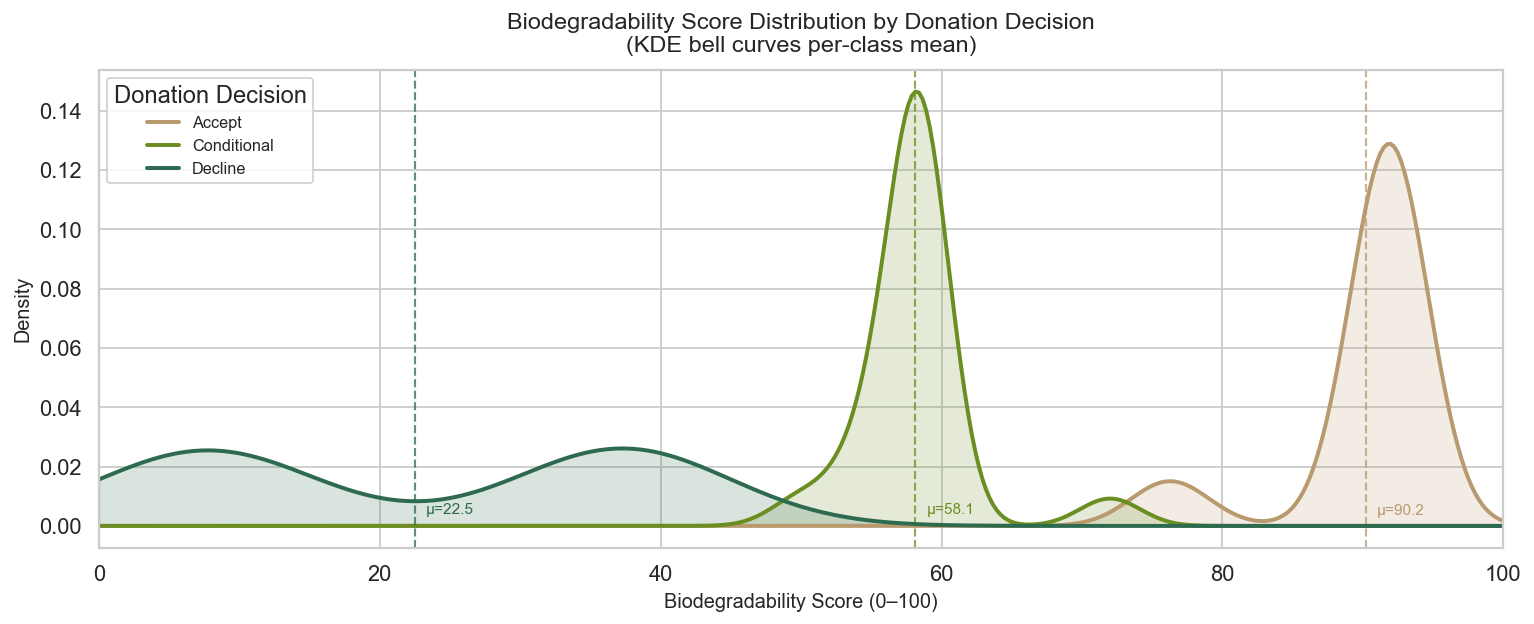

✓ 4-E-1 KDE chart saved → /Users/gyalm/Desktop/WeaveForward_FiberClassificationML/data/visualizations/history/4E1_biodeg_score_kde_20260225_020618.png


In [36]:
# ── 4-E-1  Donation decision distribution ────────────────────────────────
decision_df = spark.sql("""
    SELECT donation_decision,
           COUNT(*)                        AS item_count,
           ROUND(AVG(biodeg_score),  2)    AS avg_biodeg_score,
           ROUND(AVG(fs_bio_share),  1)    AS avg_bio_share_pct,
           ROUND(AVG(demand_index),  3)    AS avg_demand_index,
           ROUND(AVG(weight_kg),     3)    AS avg_weight_kg,
           ROUND(SUM(weight_kg),     2)    AS total_weight_kg
    FROM donations_transformed
    GROUP BY donation_decision
    ORDER BY avg_biodeg_score DESC
""")
decision_df.show()

# ── Bell-curve (KDE) — biodeg_score distribution per decision class ───────
_df = df_donors[["donation_decision", "fs_biodeg_score"]].copy()
_df["fs_biodeg_score"] = pd.to_numeric(_df["fs_biodeg_score"], errors="coerce")

DECISION_ORDER  = ["accept", "conditional", "decline"]
DECISION_COLORS = {
    "accept":      EARTH[3],
    "conditional": EARTH[6],
    "decline":     EARTH[8],
}

fig, ax = plt.subplots(figsize=(12, 5))

for decision_lbl in DECISION_ORDER:
    subset = _df.loc[_df["donation_decision"] == decision_lbl, "fs_biodeg_score"].dropna()
    if len(subset) < 2:
        continue
    color = DECISION_COLORS[decision_lbl]

    from scipy.stats import gaussian_kde
    kde    = gaussian_kde(subset, bw_method="scott")
    x_vals = np.linspace(0, 100, 400)
    y_vals = kde(x_vals)

    ax.plot(x_vals, y_vals, color=color, linewidth=2.2, label=decision_lbl.capitalize())
    ax.fill_between(x_vals, y_vals, alpha=0.18, color=color)

    mu = subset.mean()
    ax.axvline(mu, color=color, linewidth=1.2, linestyle="--", alpha=0.75)
    ax.text(mu + 0.8, ax.get_ylim()[1] * 0.02 if ax.get_ylim()[1] > 0 else 0.001,
            f"μ={mu:.1f}", color=color, fontsize=8.5, va="bottom")

ax.set_xlabel("Biodegradability Score (0–100)", fontsize=11)
ax.set_ylabel("Density", fontsize=11)
ax.set_title(
    "Biodegradability Score Distribution by Donation Decision\n"
    "(KDE bell curves per-class mean)",
    fontsize=13, pad=10,
)
ax.legend(title="Donation Decision", fontsize=9, framealpha=0.85)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(viz_path("4E1_biodeg_score_kde"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 4-E-1 KDE chart saved → {viz_path('4E1_biodeg_score_kde')}")


In [ ]:
# ── 4-E-2  Top 10 NCR cities by donation volume ───────────────────────────
spark.sql("""
    SELECT ncr_city,
           COUNT(*)                                                    AS item_count,
           COUNT(DISTINCT donation_id)                                 AS request_count,
           ROUND(AVG(biodeg_score),  2)                                AS avg_biodeg,
           ROUND(AVG(demand_index),  3)                                AS avg_demand_index,
           ROUND(AVG(weight_kg),     3)                                AS avg_weight_kg,
           ROUND(SUM(weight_kg),     2)                                AS total_weight_kg,
           SUM(CASE WHEN donation_decision = 'accept' THEN 1 ELSE 0 END) AS accepted
    FROM donations_transformed
    GROUP BY ncr_city
    ORDER BY item_count DESC
    LIMIT 10
""").show()


In [ ]:

# ── 4-E-3  Biodeg tier by clothing type + weight summary ─────────────────
spark.sql("""
    SELECT clothing_type,
           biodeg_tier,
           COUNT(*)                   AS item_count,
           ROUND(AVG(weight_kg), 3)   AS avg_weight_kg,
           ROUND(SUM(weight_kg), 2)   AS total_weight_kg
    FROM donations_transformed
    GROUP BY clothing_type, biodeg_tier
    ORDER BY clothing_type, biodeg_tier
""").show(30)


In [ ]:
# ── 4-F  Persist transformed donor requests ──────────────────────────────
PARQUET_PATH = str(PROC_DIR / "donor_requests.parquet")
CSV_PATH     = str(PROC_DIR / "donor_requests.csv")

df_transformed.write.mode("overwrite").parquet(PARQUET_PATH)

df_transformed.coalesce(1).write.mode("overwrite").option("header", True).csv(
    str(PROC_DIR / "_dr_csv_tmp"))
part_files = glob.glob(str(PROC_DIR / "_dr_csv_tmp" / "part-*.csv"))
if part_files:
    shutil.move(part_files[0], CSV_PATH)
shutil.rmtree(str(PROC_DIR / "_dr_csv_tmp"), ignore_errors=True)

print(f"✓ donor_requests.parquet → {PARQUET_PATH}")
print(f"✓ donor_requests.csv     → {CSV_PATH}")

# Pull back to pandas for all downstream feature engineering + visualization
df_ml = df_transformed.toPandas()
print(f"✓ df_ml loaded — {len(df_ml):,} rows, {len(df_ml.columns)} cols")


---
## 5 · Feature Engineering

Expands per-fiber percentages into individual numeric columns, encodes
categorical features, and defines `FEATURE_COLS` and the `donation_decision`
target for the CatBoost recommendation model.


In [ ]:
# ── 5-A  Fiber vocabulary + expand_fibers() ───────────────────────────────
FIBER_VOCAB = [k for k in BIODEG_SCORES if k != "unknown"]
PCT_COLS    = [f"pct_{f}" for f in FIBER_VOCAB]


def expand_fibers(df: pd.DataFrame) -> pd.DataFrame:
    """Expand fiber_json column into individual pct_<fiber> numeric columns."""
    fiber_data = {col: [] for col in PCT_COLS}
    for _, row in df.iterrows():
        try:    fibers = json.loads(row.get("fiber_json") or "{}")
        except: fibers = {}
        for col in PCT_COLS:
            fname = col.replace("pct_", "")
            fiber_data[col].append(float(fibers.get(fname, 0.0)))
    return pd.concat([df.reset_index(drop=True), pd.DataFrame(fiber_data)], axis=1)


print(f"✓ FIBER_VOCAB ({len(FIBER_VOCAB)} fibers), PCT_COLS ready")
print("✓ expand_fibers() ready")


In [ ]:
# ── 5-B  Build feature matrix + cleanup ──────────────────────────────────
df_feat = expand_fibers(df_ml.copy())

# Numeric cleanup
df_feat["biodeg_score"]   = pd.to_numeric(df_feat["biodeg_score"],   errors="coerce").fillna(30.0)
df_feat["fs_bio_share"]   = pd.to_numeric(df_feat["fs_bio_share"],   errors="coerce").fillna(0.0)
df_feat["demand_index"]   = pd.to_numeric(df_feat["demand_index"],   errors="coerce").fillna(0.5)
df_feat["weight_kg"]      = pd.to_numeric(df_feat["weight_kg"],      errors="coerce").fillna(0.5)
df_feat["latitude"]       = pd.to_numeric(df_feat["latitude"],       errors="coerce")
df_feat["longitude"]      = pd.to_numeric(df_feat["longitude"],      errors="coerce")
df_feat["decision_label"] = pd.to_numeric(df_feat["decision_label"], errors="coerce").fillna(0).astype(int)

# Categorical cleanup
for col, default in [("brand", "unknown"), ("clothing_type", "unknown"),
                     ("most_dominant_fiber", "unknown"), ("source", "unknown"),
                     ("biodeg_tier", "low"), ("region", "NCR"),
                     ("ncr_city", "Manila"), ("barangay", "unknown")]:
    if col not in df_feat.columns:
        df_feat[col] = default
    df_feat[col] = df_feat[col].fillna(default).str.lower().str.strip()

print(f"✓ feature matrix: {len(df_feat):,} rows × {len(df_feat.columns)} cols")
print(f"  pct_* columns: {len(PCT_COLS)}")


In [ ]:
# ── 5-B  Define feature columns + target ─────────────────────────────────

CAT_FEATURES  = ["brand", "clothing_type", "most_dominant_fiber",
                 "source", "biodeg_tier", "region", "ncr_city", "barangay"]

FEATURE_COLS  = (PCT_COLS
                 + ["fs_bio_share", "biodeg_score", "demand_index",
                    "weight_kg", "latitude", "longitude"]
                 + CAT_FEATURES)

TARGET = "decision_label"   # 0=decline, 1=conditional, 2=accept

X = df_feat[FEATURE_COLS].copy()
y = df_feat[TARGET].copy()

print("Feature summary")
print(f"  numeric  : {len(FEATURE_COLS) - len(CAT_FEATURES)}")
print(f"  categoric: {len(CAT_FEATURES)}  →  {CAT_FEATURES}")
print(f"  total    : {len(FEATURE_COLS)}")
print(f"\nTarget ({TARGET}) distribution:")
for lbl, cnt in y.value_counts().sort_index().items():
    print(f"  {DECISION_DECODE[lbl]:<12} ({lbl})  {cnt:>6,}  "
          f"{cnt/len(y)*100:.1f}%")


In [ ]:
# ── 6-A  Area/line graph — avg fiber composition per NCR city ─────────────
# Shows how material prevalence shifts across Metro Manila cities.

TOP_FIBERS = (df_feat[PCT_COLS]
              .mean()
              .nlargest(8)
              .index
              .tolist())   # e.g. pct_cotton, pct_polyester …

city_fiber = (df_feat
              .groupby("ncr_city")[TOP_FIBERS]
              .mean()
              .reset_index()
              .sort_values("ncr_city"))

fig, ax = plt.subplots(figsize=(14, 6))
x       = np.arange(len(city_fiber))
bottom  = np.zeros(len(city_fiber))

for i, col in enumerate(TOP_FIBERS):
    fiber_name = col.replace("pct_", "").capitalize()
    ax.fill_between(x, bottom, bottom + city_fiber[col].values,
                    alpha=0.75, color=EARTH[i % len(EARTH)],
                    label=fiber_name)
    ax.plot(x, bottom + city_fiber[col].values,
            color=EARTH[i % len(EARTH)], linewidth=1.2)
    bottom = bottom + city_fiber[col].values

ax.set_xticks(x)
ax.set_xticklabels(city_fiber["ncr_city"], rotation=35, ha="right", fontsize=9)
ax.set_ylabel("Average Fiber Composition (%)")
ax.set_title("Material Composition Distribution across NCR Cities\n"
             "(stacked area — top 8 fiber types)", fontsize=13, pad=10)
ax.legend(loc="upper right", fontsize=8, ncol=2,
          framealpha=0.85, title="Fiber Type")
plt.tight_layout()
plt.savefig(viz_path("6A_city_fiber_area"), dpi=150)
plt.show()
print(f"✓ 6-A saved → {viz_path('6A_city_fiber_area')}")


In [ ]:
# ── 6-B  Correlation heatmap — quantitative features × biodeg score ────────
QUANT_COLS = (PCT_COLS
              + ["fs_bio_share", "biodeg_score", "demand_index",
                 "latitude", "longitude", "decision_label"])

corr_df = df_feat[QUANT_COLS].fillna(0).corr(method="spearman")
mask    = np.triu(np.ones_like(corr_df, dtype=bool))

earth_cmap = sns.blend_palette(["#1b4332", "#d4b896", "#5c4a2a"], as_cmap=True)

fig, ax = plt.subplots(figsize=(18, 14))
sns.heatmap(corr_df, mask=mask, annot=True, fmt=".2f",
            cmap=earth_cmap, center=0,
            linewidths=0.3, linecolor="#e8e0d0",
            ax=ax, annot_kws={"size": 7})
ax.set_title(
    "Spearman Correlation — Fiber Percentages × Biodeg Score × Demand Index",
    fontsize=13, pad=12)
plt.tight_layout()
plt.savefig(viz_path("6B_correlation_heatmap"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 6-B saved → {viz_path('6B_correlation_heatmap')}")


In [ ]:
# ── 6-C  Brand distribution — top 20 brands by donation request count ─────
brand_counts = (df_feat.groupby("brand")
                .agg(count=("donation_id", "count"),
                     avg_biodeg=("biodeg_score", "mean"),
                     avg_bio_share=("fs_bio_share", "mean"))
                .reset_index()
                .sort_values("count", ascending=False)
                .head(20))

fig, ax = plt.subplots(figsize=(13, 7))
bars = ax.barh(brand_counts["brand"][::-1],
               brand_counts["count"][::-1],
               color=sns.color_palette(EARTH, len(brand_counts)))
# annotate with avg biodeg score
for bar, (_, row) in zip(bars, brand_counts[::-1].iterrows()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            f"  biodeg {row['avg_biodeg']:.0f}", va="center",
            fontsize=7.5, color="#4a2f1a")

ax.set_xlabel("Donation Requests")
ax.set_title("Top 20 Brands by Donor Request Volume\n"
             "(annotated with average biodegradability score)", fontsize=13)
ax.set_xlim(0, brand_counts["count"].max() * 1.25)
plt.tight_layout()
plt.savefig(viz_path("6C_brand_distribution"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 6-C saved → {viz_path('6C_brand_distribution')}")


In [ ]:
# ── 6-D  Fiber composition distribution — dominant fiber types ────────────
fiber_pct_mean = (df_feat[PCT_COLS]
                  .mean()
                  .sort_values(ascending=False)
                  .head(12))
labels = [c.replace("pct_", "").capitalize() for c in fiber_pct_mean.index]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
axes[0].barh(labels[::-1], fiber_pct_mean.values[::-1],
             color=sns.color_palette(EARTH, len(labels)))
axes[0].set_xlabel("Mean Fiber Composition (%)")
axes[0].set_title("Average Fiber Composition Across All Donor Requests\n"
                  "(top 12 fiber types)", fontsize=12)

# Pie chart for top 8
colors8 = sns.color_palette(EARTH, 8)
wedges, texts, autotexts = axes[1].pie(
    fiber_pct_mean.values[:8],
    labels=labels[:8],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors8,
    pctdistance=0.8,
)
for t in autotexts:
    t.set_fontsize(8)
axes[1].set_title("Share of Top 8 Fiber Types", fontsize=12)

plt.suptitle("Fiber Composition Distribution — WeaveForward Donor Requests",
             fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig(viz_path("6D_fiber_distribution"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 6-D saved → {viz_path('6D_fiber_distribution')}")


In [ ]:
# ── 6-E  Donation decision by NCR city — stacked bar ─────────────────────
city_decision = (df_feat
                 .groupby(["ncr_city", "donation_decision"])
                 .size()
                 .unstack(fill_value=0)
                 .reindex(columns=["accept", "conditional", "decline"])
                 .sort_values("accept", ascending=False))

city_decision_pct = city_decision.div(city_decision.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
city_decision.plot(kind="bar", ax=axes[0], stacked=True,
                   color=[EARTH[3], EARTH[1], EARTH[8]])
axes[0].set_title("Donation Decisions per NCR City (Absolute)", fontsize=12)
axes[0].set_xlabel("NCR City"); axes[0].set_ylabel("Request Count")
axes[0].tick_params(axis="x", rotation=40)
axes[0].legend(title="Decision", fontsize=9)

# Percentage
city_decision_pct.plot(kind="bar", ax=axes[1], stacked=True,
                       color=[EARTH[3], EARTH[1], EARTH[8]])
axes[1].set_title("Donation Decisions per NCR City (%)", fontsize=12)
axes[1].set_xlabel("NCR City"); axes[1].set_ylabel("Share (%)")
axes[1].tick_params(axis="x", rotation=40)
axes[1].legend(title="Decision", fontsize=9)

plt.tight_layout()
plt.savefig(viz_path("6E_decision_by_city"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 6-E saved → {viz_path('6E_decision_by_city')}")


---
## 7 · Donation Recommendation Model

Trains a CatBoost multi-class classifier to predict `donation_decision`
(`accept` / `conditional` / `decline`) from fiber compositions, biodeg score,
NCR city demand index, and climate zone.  
Optuna performs 30-trial hyperparameter search with 3-fold stratified CV.


In [ ]:
# ── 7-A  Train / test split ───────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {len(X_train):,}  |  Test: {len(X_test):,}")
print("Label distribution — train:", dict(y_train.value_counts().sort_index()))
print("Label distribution — test :", dict(y_test.value_counts().sort_index()))


In [ ]:
# ── 7-B  Optuna hyperparameter search (30 trials, 3-fold CV) ─────────────

def objective(trial: optuna.Trial) -> float:
    params = {
        "iterations":          trial.suggest_int("iterations", 200, 800),
        "depth":               trial.suggest_int("depth", 4, 10),
        "learning_rate":       trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg":         trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count":        trial.suggest_int("border_count", 32, 255),
        "loss_function":       "MultiClass",
        "eval_metric":         "Accuracy",
        "cat_features":        CAT_FEATURES,
        "random_seed":         42,
        "verbose":             False,
        "od_type":             "Iter",
        "od_wait":             40,
    }
    skf    = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for tr_i, va_i in skf.split(X_train, y_train):
        m = CatBoostClassifier(**params)
        m.fit(X_train.iloc[tr_i], y_train.iloc[tr_i],
              eval_set=(X_train.iloc[va_i], y_train.iloc[va_i]),
              use_best_model=True, verbose=False)
        scores.append(f1_score(y_train.iloc[va_i],
                               m.predict(X_train.iloc[va_i]),
                               average="weighted"))
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize",
                             study_name="weaveforward_donation_rec")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"\n✓ Best CV F1 (weighted): {study.best_value:.4f}")
print("  Best params:", study.best_params)


In [ ]:
# ── 7-C  Final model training + save ─────────────────────────────────────
best_params = study.best_params | {
    "loss_function": "MultiClass",
    "eval_metric":   "Accuracy",
    "cat_features":  CAT_FEATURES,
    "random_seed":   42,
    "verbose":       100,
}

model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          plot=False)

MODEL_PATH = MODEL_DIR / "catboost_donation_rec.cbm"
model.save_model(str(MODEL_PATH))

META = {
    "trained_at":     datetime.utcnow().isoformat(),
    "notebook":       "weaveforward_fiber_recommendation.ipynb",
    "target":         "donation_decision (0=decline, 1=conditional, 2=accept)",
    "feature_cols":   FEATURE_COLS,
    "cat_features":   CAT_FEATURES,
    "decision_encode": DECISION_ENCODE,
    "best_params":    study.best_params,
    "best_cv_f1":     study.best_value,
    "biodeg_scores":  BIODEG_SCORES,
}
META_PATH = MODEL_DIR / "donation_rec_metadata.json"
with open(META_PATH, "w") as f:
    json.dump(META, f, indent=2)

print(f"✓ model saved  → {MODEL_PATH}")
print(f"✓ metadata     → {META_PATH}")


---
## 8 · Evaluation Matrices


In [ ]:
# ── 8-A  Prediction + classification report ───────────────────────────────
LABELS = ["decline", "conditional", "accept"]

y_pred = model.predict(X_test).flatten().astype(int)
y_prob = model.predict_proba(X_test)

metrics = {
    "Accuracy":             accuracy_score(y_test, y_pred),
    "F1 (weighted)":        f1_score(y_test, y_pred, average="weighted"),
    "F1 (macro)":           f1_score(y_test, y_pred, average="macro"),
    "Precision (weighted)": precision_score(y_test, y_pred, average="weighted",
                                            zero_division=0),
    "Recall (weighted)":    recall_score(y_test, y_pred, average="weighted",
                                         zero_division=0),
    "ROC-AUC (OvR)":       (roc_auc_score(y_test, y_prob, multi_class="ovr")
                             if len(set(y_test)) > 1 else None),
}

print("=" * 50)
print("  WeaveForward — Donation Recommendation Model")
print("=" * 50)
for k, v in metrics.items():
    if v is not None:
        print(f"  {k:<28} {v:.4f}")
    else:
        print(f"  {k:<28} N/A")
print()
print(classification_report(y_test, y_pred, target_names=LABELS))


In [ ]:
# ── 8-B  Confusion matrix + FP/FN earth-tone chart ───────────────────────
cm     = confusion_matrix(y_test, y_pred)
cm_std = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Normalised confusion matrix
earth_seq = sns.light_palette(EARTH[4], as_cmap=True)
sns.heatmap(cm_std, annot=True, fmt=".2f", cmap=earth_seq,
            xticklabels=LABELS, yticklabels=LABELS, ax=axes[0],
            linewidths=0.5, linecolor="#e8e0d0")
axes[0].set_title("Confusion Matrix (Normalised)", fontsize=13)
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

# FP / FN bar
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
err_df = pd.DataFrame({"FP": fp, "FN": fn}, index=LABELS)
err_df.plot(kind="bar", ax=axes[1], color=[EARTH[0], EARTH[6]], edgecolor="white")
axes[1].set_title("False Positives & False Negatives per Class", fontsize=13)
axes[1].set_xlabel("Donation Decision"); axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.savefig(viz_path("8B_confusion_fp_fn"), dpi=150)
plt.show()
print(f"✓ 8-B saved → {viz_path('8B_confusion_fp_fn')}")
print("FP/FN table:\n", err_df.to_string())


In [ ]:
# ── 8-C  Feature importance + SHAP ───────────────────────────────────────
feat_imp = pd.Series(model.get_feature_importance(),
                     index=FEATURE_COLS).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top-20 importance bar
top_imp = feat_imp.head(20)
axes[0].barh(top_imp.index[::-1], top_imp.values[::-1],
             color=sns.color_palette(EARTH, 20))
axes[0].set_title("CatBoost Feature Importance — Top 20", fontsize=12)
axes[0].set_xlabel("Importance Score")

# SHAP summary — accept class (label=2)
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[2], X_test,
                  feature_names=FEATURE_COLS,
                  show=False, plot_type="dot", max_display=15)
plt.title("SHAP Summary — 'accept' Class", fontsize=12)

plt.tight_layout()
plt.savefig(viz_path("8C_feature_importance_shap"), dpi=150, bbox_inches="tight")
plt.show()
print(f"✓ 8-C saved → {viz_path('8C_feature_importance_shap')}")


In [ ]:
# ── 8-D  Persist predictions + evaluation report ─────────────────────────
X_all   = df_feat[FEATURE_COLS]
preds   = model.predict(X_all).flatten().astype(int)
proba   = model.predict_proba(X_all)

df_results = df_feat[[
    "donation_id", "brand", "clothing_type", "most_dominant_fiber",
    "fs_bio_share", "biodeg_score", "biodeg_tier",
    "ncr_city", "demand_index", "climate_zone",
    "donation_decision", "decision_label",
]].copy()
df_results["predicted_label"]    = preds
df_results["predicted_decision"] = [DECISION_DECODE[p] for p in preds]
df_results["proba_decline"]      = proba[:, 0].round(4)
df_results["proba_conditional"]  = proba[:, 1].round(4)
df_results["proba_accept"]       = proba[:, 2].round(4)
df_results["predicted_at"]       = datetime.utcnow().isoformat()

RESULTS_CSV  = PROC_DIR / "donation_predictions.csv"
EVAL_JSON    = MODEL_DIR / "donation_rec_eval_report.json"

df_results.to_csv(RESULTS_CSV, index=False)

eval_report = {
    "evaluated_at":       datetime.utcnow().isoformat(),
    "test_size":          int(len(y_test)),
    "total_records":      int(len(df_results)),
    "metrics":            {k: round(float(v), 4)
                           for k, v in metrics.items() if v is not None},
    "confusion_matrix":   cm.tolist(),
    "class_names":        LABELS,
    "fp_per_class":       dict(zip(LABELS, fp.tolist())),
    "fn_per_class":       dict(zip(LABELS, fn.tolist())),
    "decision_distribution": df_results["predicted_decision"].value_counts().to_dict(),
    "model_path":          str(MODEL_PATH),
}
with open(EVAL_JSON, "w") as f:
    json.dump(eval_report, f, indent=2)

print(f"✓ donation_predictions.csv  → {RESULTS_CSV}")
print(f"✓ evaluation report          → {EVAL_JSON}")
print("\nPredicted decision distribution:")
print(df_results["predicted_decision"].value_counts().to_string())
